In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request as req
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Dataset from mtgjson.com
raw = pd.read_json("./data/mtg/AllSets-x.json")

In [3]:
raw.head()

10E  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               black   
cards    [{'imageName': 'ancestor's chosen', 'manaCost'...   
code                                                   10E   

                                                       2ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'air elemental', 'manaCost': '{...   
code                                                   2ED   

                                                       3ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'air elemental', 'manaCost': '{...   
code                                                   3ED   

                                                       4ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'abomination', 'manaCost': '{3}...   
code                                                   4ED   

                                                       5DN  \
block                                             Mirrodin   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               black   
cards    [{'imageName': 'abuna's chant', 'manaCost': '{...   
code                                                   5DN   

                                                       5ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'abbey gargoyles', 'manaCost': ...   
code                                                   5ED   

                                                       6ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'animate wall', 'manaCost': '{W...   
code                                                   6ED   

                                                       7ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'angelic page', 'manaCost': '{1...   
code                                                   7ED   

                                                       8ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'angel of mercy', 'manaCost': '...   
code                                                   8ED   

                                                       9ED  \
block                                                  NaN   
booster  [rare, uncommon, uncommon, uncommon, common, c...   
border                                               white   
cards    [{'imageName': 'angel of mercy', 'manaCost': '...   
code                                                   9ED   

                               ...                          \
block                          ...                           
booster                        ...                           
border                         ...                           
cards                          ...                           
code           

In [4]:
def download_image_with_id(image_id, replace=False, show_inline=False):
    fileName = "./data/mtg/images/" + image_id + ".jpg"
    exists = os.path.exists(fileName)
    if replace or not exists:
        print("Downloading image... " + fileName)
        req.urlretrieve("http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=" + image_id + "&type=card", fileName)
    
    if show_inline:
        img = Image.open(fileName, 'r')
        plt.imshow(np.asarray(img))
        plt.show()
    
    return fileName

artist                                                Pete Venters
cmc                                                              7
colorIdentity                                                  [W]
colors                                                     [White]
flavor                         "The will of all, by my hand done."
foreignNames     [{'name': '祖灵的爱民', 'multiverseid': 147645, 'la...
id                        ab1ab474019e4e76c66e2b524d354cb7c3212616
imageName                                        ancestor's chosen
layout                                                      normal
legalities       [{'legality': 'Legal', 'format': 'Commander'},...
manaCost                                                 {5}{W}{W}
mciNumber                                                 10e/en/1
multiverseid                                                130550
name                                             Ancestor's Chosen
number                                                        

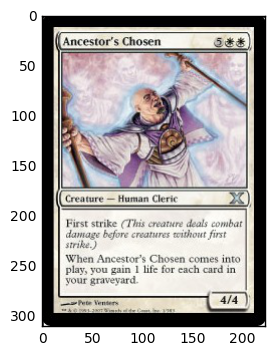

'./data/mtg/images/130550.jpg'

In [5]:
sample_set = pd.DataFrame(raw[raw.columns.values[0]]).transpose()
sample_card = pd.io.json.json_normalize(sample_set.cards.iloc[0]).iloc[0]
print(sample_card)
img_id = str(sample_card.multiverseid)
download_image_with_id(img_id, show_inline=True)

In [6]:
del sample_set, sample_card, img_id

In [7]:
keeps = ['name', 'colorIdentity', 'colors', 'type', 'types', 'subtypes', 'supertypes', 'cmc', 'power', 'toughness', 'flavor', 'text', 'legalities', 'multiverseid']

In [8]:
mtg = []
for col in raw.columns.values:
    cards = pd.DataFrame(raw[col]['cards'])
    cards = cards.loc[:,keeps]
    cards['setname'] = col
    mtg.append(cards)

In [9]:
del cards, raw

In [10]:
mtg = pd.concat(mtg, ignore_index=True)

In [11]:
mtg.shape

(31705, 15)

In [12]:
mtg.head()

name colorIdentity   colors                     type  \
0  Ancestor's Chosen           [W]  [White]  Creature — Human Cleric   
1     Angel of Mercy           [W]  [White]         Creature — Angel   
2   Angelic Blessing           [W]  [White]                  Sorcery   
3     Angelic Chorus           [W]  [White]              Enchantment   
4       Angelic Wall           [W]  [White]          Creature — Wall   

           types         subtypes supertypes  cmc power toughness  \
0     [Creature]  [Human, Cleric]        NaN  7.0     4         4   
1     [Creature]          [Angel]        NaN  5.0     3         3   
2      [Sorcery]              NaN        NaN  3.0   NaN       NaN   
3  [Enchantment]              NaN        NaN  5.0   NaN       NaN   
4     [Creature]           [Wall]        NaN  2.0     0         4   

                                              flavor  \
0                "The will of all, by my hand done."   
1          Every tear shed is a drop of immortality.   
2  Only the warrior who can admit mortal weakness...   
3  The harmony of the glorious is a dirge to the ...   
4  "The Ancestor protects us in ways we can't beg...   

                                                text  \
0  First strike (This creature deals combat damag...   
1  Flying\nWhen Angel of Mercy enters the battlef...   
2  Target creature gets +3/+3 and gains flying un...   
3  Whenever a creature enters the battlefield und...   
4     Defender (This creature can't attack.)\nFlying   

                                          legalities  multiverseid setname  
0  [{'legality': 'Legal', 'format': 'Commander'},...      130550.0     10E  
1  [{'legality': 'Legal', 'format': 'Commander'},...      129465.0     10E  
2  [{'legality': 'Legal', 'format': 'Commander'},...      129711.0     10E  
3  [{'legality': 'Legal', 'format': 'Commander'},...      129710.0     10E  
4  [{'legality': 'Legal', 'format': 'Commander'},...      129671.0     10E

In [13]:
mtg.dtypes

name              object
colorIdentity     object
colors            object
type              object
types             object
subtypes          object
supertypes        object
cmc              float64
power             object
toughness         object
flavor            object
text              object
legalities        object
multiverseid     float64
setname           object
dtype: object

In [14]:
# Data trimming
# Take only the ones with images
mtg = mtg.loc[lambda mtg: ~mtg.multiverseid.isnull()]
# Remove the ones without a type
mtg = mtg.loc[~mtg.types.apply(lambda x: isinstance(x, float))]
mtg.shape

(29481, 15)

In [15]:
# Recast dtypes
mtg['multiverseid'] = mtg['multiverseid'].astype(int).astype(str)
mtg[['power', 'toughness']] = mtg[['power', 'toughness']].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [16]:
mtg.dtypes

name              object
colorIdentity     object
colors            object
type              object
types             object
subtypes          object
supertypes        object
cmc              float64
power            float64
toughness        float64
flavor            object
text              object
legalities        object
multiverseid      object
setname           object
dtype: object

In [17]:
creatures = mtg.loc[mtg.types.apply(lambda x: 'Creature' in x)]
creatures = creatures.loc[~creatures.subtypes.apply(lambda x: isinstance(x,float))]

In [18]:
print(creatures.shape)
creatures.head()

(13799, 15)


name colorIdentity   colors                     type  \
0  Ancestor's Chosen           [W]  [White]  Creature — Human Cleric   
1     Angel of Mercy           [W]  [White]         Creature — Angel   
4       Angelic Wall           [W]  [White]          Creature — Wall   
6   Aven Cloudchaser           [W]  [White]  Creature — Bird Soldier   
7     Ballista Squad           [W]  [White]   Creature — Human Rebel   

        types         subtypes supertypes  cmc  power  toughness  \
0  [Creature]  [Human, Cleric]        NaN  7.0    4.0        4.0   
1  [Creature]          [Angel]        NaN  5.0    3.0        3.0   
4  [Creature]           [Wall]        NaN  2.0    0.0        4.0   
6  [Creature]  [Bird, Soldier]        NaN  4.0    2.0        2.0   
7  [Creature]   [Human, Rebel]        NaN  4.0    2.0        2.0   

                                              flavor  \
0                "The will of all, by my hand done."   
1          Every tear shed is a drop of immortality.   
4  "The Ancestor protects us in ways we can't beg...   
6  "At the Reapportionment, Eagle begged to be hu...   
7  The perfect antidote for a tightly packed form...   

                                                text  \
0  First strike (This creature deals combat damag...   
1  Flying\nWhen Angel of Mercy enters the battlef...   
4     Defender (This creature can't attack.)\nFlying   
6  Flying (This creature can't be blocked except ...   
7  {X}{W}, {T}: Ballista Squad deals X damage to ...   

                                          legalities multiverseid setname  
0  [{'legality': 'Legal', 'format': 'Commander'},...       130550     10E  
1  [{'legality': 'Legal', 'format': 'Commander'},...       129465     10E  
4  [{'legality': 'Legal', 'format': 'Commander'},...       129671     10E  
6  [{'legality': 'Legal', 'format': 'Commander'},...       129470     10E  
7  [{'legality': 'Legal', 'format': 'Commander'},...       129477     10E

In [19]:
# Download Images for creatures
# for image_id in creatures.multiverseid.values:
#     download_image_with_id(image_id)
# print("Done downloading...")

In [20]:
flavs = creatures.loc[~creatures.flavor.apply(lambda x: isinstance(x, float))].flavor
descriptions = np.array(flavs.values)
del flavs

In [21]:
descriptions

array(['"The will of all, by my hand done."',
       'Every tear shed is a drop of immortality.',
       '"The Ancestor protects us in ways we can\'t begin to comprehend."\n—Mystic elder',
       ...,
       "These small but intelligent Dragons and their Olesian allies held back the tide of Pashalik Mons's hordes of Goblin Raiders.\nDragonCon 1994",
       'Loyal and passionate in battle, the Windseeker tribe roams the Green Lands near the Honeyed Sea.',
       'The wizard Greensleeves called a Giant Badger to her aid in an battle with the desert mage Karli.'], dtype=object)

In [22]:
n_desc = len(descriptions)
all_text = ''.join(descriptions[:int(n_desc/2)]).lower()

In [23]:
chars = sorted(list(set(all_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [24]:
n_char = len(all_text)
n_vocab = len(chars)
print("Total Characters... ", n_char)
print("Vocab... ", n_vocab)

Total Characters...  470509
Vocab...  65


In [25]:
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_char - seq_length, 1):
    seq_in = all_text[i : i+seq_length]
    seq_out = all_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total patterns... ", n_patterns)

Total patterns...  470409


In [26]:
#  [samples, seq length, length of each vector]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X/ float(n_vocab)
# one hot encode the output
y = np_utils.to_categorical(dataY)

In [27]:
# Build model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

In [28]:
# Train or load model (comment out the unrequired one)
# # Train...
# model.compile(loss='categorical_crossentropy', optimizer='adam')
# # save checkpoint
# filepath = "./saved/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# model.fit(X, y, nb_epoch=4, batch_size=64, callbacks=callbacks_list)

# Load...
filepath = "./saved/weights-improvement-00-2.7186.hdf5"
model.load_weights(filepath)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [29]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [30]:
# Generate more flavors...
start = np.random.randint(0, len(dataX) - 1)
pattern = dataX[start]
print("Seed... ", ''.join([int_to_char[value] for value in pattern]))
for i in range(100):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x/float(n_vocab)
    prediction = model.predict(x, verbose=0)
    prediction = prediction.reshape(prediction.shape[1])
    index = sample(prediction, 0.2)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone")

Seed...   a sign that dinner is on the way."
—klazina jansdotter, leader of the order of the sacred torch"the
 sieel of the siee of the sart of the sarts of the sane of the sane of the siat of the sore of the s
Done
